In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


# --- 1. Define Constants and Features ---
FILE_NAME = '/kaggle/input/reviews-modelling-data/modelling_data.csv'
TARGET_COL = 'stars_x'
GROUP_COL = 'business_id'
TEXT_COL = 'text'

BOOLEAN_F = ['has_exclamation', 'has_question', 'is_shouting']
CATEGORICAL_F = ['food_sentiment', 'service_sentiment', 'atmosphere_sentiment', 'overall_sentiment']
NUMERICAL_F = ['grade_level']

# All features that will be used as input (X)
ALL_INPUT_FEATURES = [TEXT_COL] + BOOLEAN_F + CATEGORICAL_F + NUMERICAL_F

In [2]:
# --- 2. Load and Prepare Data ---
try:
    df = pd.read_csv(FILE_NAME)
    print(f"Data loaded successfully from '{FILE_NAME}'.")
except FileNotFoundError:
    print(f"ERROR: File '{FILE_NAME}' not found. Please ensure the file is uploaded.")
    # Exit the script if the file cannot be loaded
    exit()

# Data Cleaning and Preparation for Robust Modeling
df.dropna(subset=[TARGET_COL, GROUP_COL, TEXT_COL], inplace=True)
# Fill NaNs for categorical/boolean/numerical columns to prevent data loss in the remaining rows
df[CATEGORICAL_F] = df[CATEGORICAL_F].fillna('missing_category')
df[BOOLEAN_F] = df[BOOLEAN_F].fillna(False)
df[NUMERICAL_F] = df[NUMERICAL_F].fillna(df[NUMERICAL_F].mean()) # Fill numerical NaNs with the mean

# Define X, y, and groups after cleaning
y = df[TARGET_COL] 
X = df[ALL_INPUT_FEATURES]
groups = df[GROUP_COL] 

Data loaded successfully from '/kaggle/input/reviews-modelling-data/modelling_data.csv'.


In [3]:
# --- 3. Stratified Group Split (80/20) ---
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

try:
    # Get the indices for the 80/20 split, respecting star rating stratification and business grouping
    train_index, test_index = next(sgkf.split(X, y, groups))
except ValueError as e:
    # Fallback if a group or class is too small to stratify
    from sklearn.model_selection import train_test_split
    print("\nWARNING: StratifiedGroupKFold failed. Falling back to standard stratified split.")
    train_index, test_index = train_test_split(df.index, test_size=0.2, stratify=y, random_state=42)

# Apply the indices to create the training and testing sets
X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]
business_ids_test = groups.loc[test_index] 

print(f"\nTraining Set Size: {len(X_train)} | Testing Set Size: {len(X_test)}")
print(f"Test set unique businesses: {business_ids_test.nunique()}")


Training Set Size: 37828 | Testing Set Size: 8629
Test set unique businesses: 134


In [4]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import torch
from collections import Counter

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
def nltk_tokenizer(text):
    tokens = word_tokenize(text)
    return [t.lower() for t in tokens if t.isalnum()]  # lowercase + remove punctuation

# Build vocabulary from training set
all_tokens = [token for text in X_train['text'] for token in nltk_tokenizer(text)]
token_counts = Counter(all_tokens)

vocab_size = 10000
most_common = token_counts.most_common(vocab_size-2)  # leave 0=<pad>, 1=<unk>
vocab = {word: i+2 for i, (word, _) in enumerate(most_common)}
vocab["<pad>"] = 0
vocab["<unk>"] = 1


In [6]:
import gensim.downloader as api
import numpy as np

# Load GloVe
glove_model = api.load("glove-wiki-gigaword-100")  # 100-dim embeddings
embed_dim = 100

# Build embedding matrix
embedding_matrix = np.zeros((vocab_size, embed_dim))

for word, idx in vocab.items():
    if word in glove_model:
        embedding_matrix[idx] = glove_model[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embed_dim,))

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

[==================================================] 100.0% 128.1/128.1MB downloaded


In [7]:
def text_to_sequence(text, vocab, maxlen=200):
    tokens = [t for t in nltk_tokenizer(text) if t.isalnum()]
    seq = [vocab.get(token, vocab["<unk>"]) for token in tokens]
    # Pad or truncate
    if len(seq) < maxlen:
        seq += [vocab["<pad>"]] * (maxlen - len(seq))
    else:
        seq = seq[:maxlen]
    return seq

X_train_seq = torch.tensor([text_to_sequence(t, vocab) for t in X_train['text']], dtype=torch.long)
X_test_seq = torch.tensor([text_to_sequence(t, vocab) for t in X_test['text']], dtype=torch.long)

In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

bool_cols = ["has_exclamation", "has_question", "is_shouting"]
sentiment_cols = ["food_sentiment", "service_sentiment", "atmosphere_sentiment", "overall_sentiment"]

numeric_col = ["grade_level"]


# Fit on training data
onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

X_train_cat = onehot.fit_transform(X_train[BOOLEAN_F + CATEGORICAL_F])
X_test_cat = onehot.transform(X_test[BOOLEAN_F + CATEGORICAL_F])

X_train_num = scaler.fit_transform(X_train[numeric_col])
X_test_num = scaler.transform(X_test[numeric_col])

# Combine
X_train_meta = np.hstack([X_train_cat, X_train_num])
X_test_meta = np.hstack([X_test_cat, X_test_num])

# Convert to tensors
X_train_meta = torch.tensor(X_train_meta, dtype=torch.float32)
X_test_meta = torch.tensor(X_test_meta, dtype=torch.float32)

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class ReviewsCNN(nn.Module):
    def __init__(
        self, 
        vocab_size, 
        embed_dim, 
        embedding_matrix,
        meta_input_dim,
        meta_hidden_dim=64,
        num_filters=100, 
        kernel_sizes=[3,4,5], 
        text_hidden_dim=128,
        combined_hidden_dim=128,
        dropout=0.5,
        num_class=5
    ):
        super().__init__()

        # -- Embedding --
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.embedding.weight = nn.Parameter(embedding_matrix)
        self.embedding.weight.requires_grad = True

        # -- CNN --
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embed_dim, 
                out_channels=num_filters, 
                kernel_size=k,
                padding=k//2
            )
            for k in kernel_sizes
        ])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(num_filters) for _ in kernel_sizes
        ])
        self.text_dropout = nn.Dropout(dropout)
        self.text_fc = nn.Linear(num_filters * len(kernel_sizes)*2, text_hidden_dim)

        # -- Meta MLP --
        self.meta_fc = nn.Sequential(
            nn.Linear(meta_input_dim, meta_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(meta_hidden_dim, meta_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # -- Combined --
        self.combined_fc = nn.Sequential(
            nn.Linear(text_hidden_dim + meta_hidden_dim, combined_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(combined_hidden_dim, num_class)
        )

    def forward(self, text, meta):
        # -- Text CNN -- 
        text = self.embedding(text)
        text = text.permute(0, 2, 1)

        conv_outputs = [
            torch.relu(self.bns[i](self.convs[i](text)))
            for i in range(len(self.convs))
        ]
        pooled = [
                torch.cat([
                    torch.max(out, dim=2)[0],
                    torch.mean(out, dim=2)
                ], dim=1)
                for out in conv_outputs
            ]
        text_features = torch.cat(pooled, dim=1)
        text_features = self.text_dropout(text_features)
        text_hidden = self.text_fc(text_features)

        # -- Meta branch -- 
        meta_features = self.meta_fc(meta)

        # -- Combined --
        combined = torch.cat([text_hidden, meta_features], dim=1)

        # -- Final --
        out = self.combined_fc(combined)
        
        return out

In [10]:

vocab_size = len(vocab)
embed_dim = 100
hidden_dim = 256
meta_dim = X_train_meta.shape[1]
output_dim = 5

num_filters = 128
kernel_sizes = [3,5]

num_epochs = 50
batch_size = 32
accum_steps = 2
patience = 5
min_delta = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ReviewsCNN(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    embedding_matrix=embedding_matrix,
    meta_input_dim=meta_dim,
    meta_hidden_dim=128,
    num_filters=num_filters,
    kernel_sizes=kernel_sizes,
    text_hidden_dim=hidden_dim,
    combined_hidden_dim=300,
    dropout=0.3,
    num_class=output_dim
).to(device)

In [11]:
from torch.utils.data import Dataset

class ReviewDataset(Dataset):
    def __init__(self, text_tensors, meta_features, labels):
        self.text_tensors = text_tensors
        self.meta_features = meta_features

        if isinstance(labels, (pd.Series, pd.DataFrame)):
            self.labels = torch.tensor(labels.values - 1, dtype=torch.long)
        else:
            self.labels = labels.long()
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        text = self.text_tensors[idx]
        meta = self.meta_features[idx]
        label = self.labels[idx]
        return text, meta, label


In [12]:
from torch.utils.data import DataLoader

# Shift labels 1-5 → 0-4
y_train_tensor = torch.tensor(y_train.values - 1, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values - 1, dtype=torch.long)

# Create datasets
train_dataset = ReviewDataset(X_train_seq, X_train_meta, y_train_tensor)
test_dataset = ReviewDataset(X_test_seq, X_test_meta, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:

from collections import Counter
import torch

# Calculate class weights: inverse of frequency
counts = y_train.value_counts().sort_index()  # ensure order matches class indices 0-4
weights = 1.0 / counts.values               # inverse frequency
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([
    {"params": model.embedding.parameters(), "lr": 1e-4},
    {"params": [p for n,p in model.named_parameters() if "embedding" not in n], "lr":1e-3}
])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,
    patience=2
)


In [ ]:
from tqdm import tqdm 

best_val_loss = float('inf')
early_stop_counter = 0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    # -------- TRAIN MODE --------
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    optimizer.zero_grad()

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)
    
    for i, (text_batch, meta_batch, labels) in enumerate(pbar):
        text_batch = text_batch.to(device)
        meta_batch = meta_batch.to(device)
        labels = labels.to(device)

        #optimizer.zero_grad()
        outputs = model(text_batch, meta_batch)
        loss = criterion(outputs, labels)

        # gradient accumulation
        loss = loss / accum_steps
        loss.backward()

        if (i + 1) % accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        train_loss += loss.item() * accum_steps

        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

        pbar.set_postfix(loss=train_loss/(i+1), acc=train_correct/train_total)

    train_acc = train_correct / train_total
    train_losses.append(train_loss/(i+1))
    train_accuracies.append(train_acc)

    # -------- VALIDATION --------
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        val_bar = tqdm(test_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)
        for text_batch, meta_batch, labels in val_bar:
            text_batch = text_batch.to(device)
            meta_batch = meta_batch.to(device)
            labels = labels.to(device)

            outputs = model(text_batch, meta_batch)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            val_bar.set_postfix(loss=val_loss/(i+1), acc=val_correct/val_total)

        val_loss /= len(test_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

    # Scheduler update
    if scheduler is not None:
        scheduler.step(val_loss)

    print(f"Epoch {epoch} | "
      f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f} | "
      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # -------- EARLY STOPPING --------
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_cnn_model.pth")
    else:
        early_stop_counter += 1
    if early_stop_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}")
        break


Epoch 1 | Train Loss: 0.9951, Train Acc: 0.5573 | Val Loss: 0.9157, Val Acc: 0.5899


Epoch 2 | Train Loss: 0.9131, Train Acc: 0.5992 | Val Loss: 0.8825, Val Acc: 0.6173


Epoch 3 | Train Loss: 0.8804, Train Acc: 0.6128 | Val Loss: 0.8468, Val Acc: 0.6275


Epoch 4 | Train Loss: 0.8632, Train Acc: 0.6203 | Val Loss: 0.8481, Val Acc: 0.6350


Epoch 5 | Train Loss: 0.8445, Train Acc: 0.6318 | Val Loss: 0.8490, Val Acc: 0.6332


Epoch 6 | Train Loss: 0.8281, Train Acc: 0.6397 | Val Loss: 0.8245, Val Acc: 0.6348


Epoch 7 | Train Loss: 0.8173, Train Acc: 0.6442 | Val Loss: 0.8115, Val Acc: 0.6515


Epoch 8 | Train Loss: 0.8005, Train Acc: 0.6530 | Val Loss: 0.8159, Val Acc: 0.6461


Epoch 9 | Train Loss: 0.7898, Train Acc: 0.6548 | Val Loss: 0.8096, Val Acc: 0.6480


Epoch 10 | Train Loss: 0.7816, Train Acc: 0.6587 | Val Loss: 0.7949, Val Acc: 0.6581


Epoch 11 | Train Loss: 0.7695, Train Acc: 0.6626 | Val Loss: 0.7899, Val Acc: 0.6608


Epoch 12 | Train Loss: 0.7509, Train Acc: 0.6705 | Val Loss: 0.7941, Val Acc: 0.6581


Epoch 13 | Train Loss: 0.7392, Train Acc: 0.6776 | Val Loss: 0.7896, Val Acc: 0.6560


Epoch 14 | Train Loss: 0.7261, Train Acc: 0.6818 | Val Loss: 0.7873, Val Acc: 0.6631


Epoch 15 | Train Loss: 0.7122, Train Acc: 0.6868 | Val Loss: 0.7934, Val Acc: 0.6631


Epoch 16 | Train Loss: 0.7005, Train Acc: 0.6922 | Val Loss: 0.8040, Val Acc: 0.6616


Epoch 17 | Train Loss: 0.6808, Train Acc: 0.7023 | Val Loss: 0.7987, Val Acc: 0.6577


Epoch 18 | Train Loss: 0.6408, Train Acc: 0.7229 | Val Loss: 0.8109, Val Acc: 0.6610


Epoch 19 | Train Loss: 0.6256, Train Acc: 0.7269 | Val Loss: 0.8321, Val Acc: 0.6558
Early stopping triggered at epoch 19


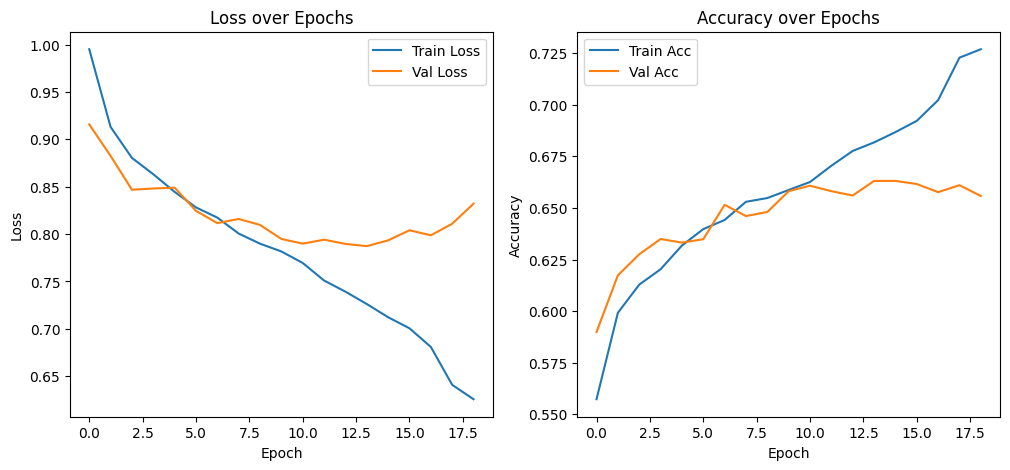

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()


Accuracy: 0.6631
Macro F1: 0.5868
Macro Precision: 0.6032
Macro Recall: 0.5799

Classification Report:

              precision    recall  f1-score   support

           0     0.7381    0.7784    0.7577      1137
           1     0.4521    0.4066    0.4282       755
           2     0.5323    0.3545    0.4256      1024
           3     0.5376    0.4964    0.5162      2089
           4     0.7560    0.8637    0.8063      3624

    accuracy                         0.6631      8629
   macro avg     0.6032    0.5799    0.5868      8629
weighted avg     0.6476    0.6631    0.6514      8629



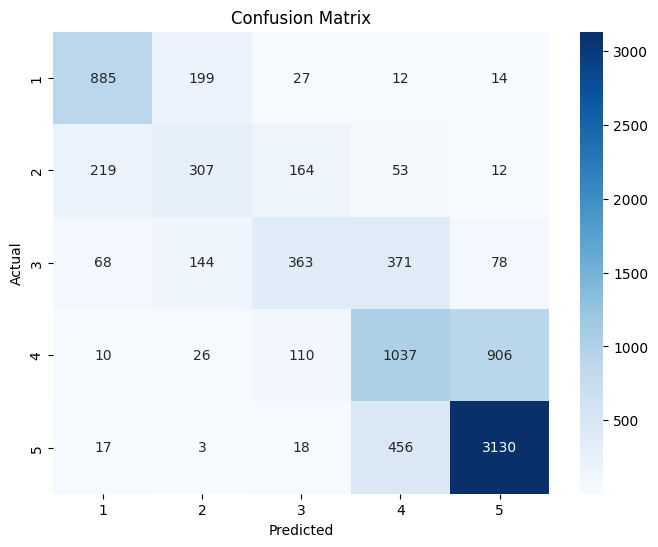

In [18]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load best model
model.load_state_dict(torch.load("best_cnn_model.pth"))
model.eval()
model.to(device)

all_preds = []
all_labels = []

# Iterate over test_loader
with torch.no_grad():
    for text, meta, labels in test_loader:
        text, meta = text.to(device), meta.to(device)
        outputs = model(text, meta)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Classification metrics
acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
macro_precision = precision_score(all_labels, all_preds, average='macro')
macro_recall = recall_score(all_labels, all_preds, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}\n")

print("Classification Report:\n")
print(classification_report(all_labels, all_preds, digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
